# Homomorphic encryption simulation of Szegedy's quantum walk on a bipartite graph

In this notebook we show how to simulate the quantum homomorphic encryption of Szegedy's quantum walk [[1]](https://ieeexplore.ieee.org/document/1366222) on a bipartite graph using the classical-quantum circuits from [[2]](https://arxiv.org/abs/2412.01966) with CQC-QHE.

## Table of Contents

- [Packages](#0)
- [1 - Naive quantum walk simulation](#1)
- [2 - Compiling the quantum circuit into Clifford+T gates](#2)
- [3 - Homomorphic simulation](#3)
- [4 - Simplified homomorphic simulation](#4)
- [5 - Deterministic simulation with SQUWALS](#5)
- [6 - References](#6)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram, plot_distribution

import cqc_qhe as cqc

The code has been tested on qiskit 1.1.0, and qiskit-aer 0.14.1.

In [2]:
import qiskit
qiskit.__version__

'1.1.0'

In [3]:
import qiskit_aer
qiskit_aer.__version__

'0.14.2'

<a name='1'></a>
## 1 - Naive quantum walk simulation

First, we construct the circuit that produces the initial state, and is run by Client.

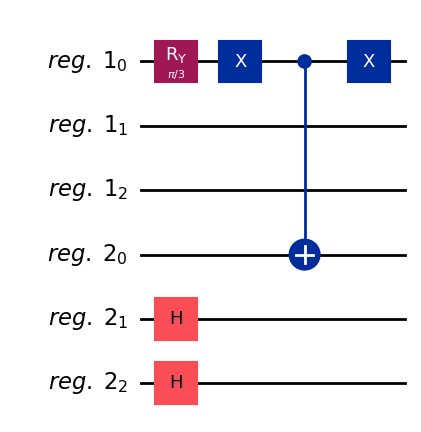

In [4]:
qr_1 = QuantumRegister(3,'reg. 1')
qr_2 = QuantumRegister(3,'reg. 2')

init_circ = QuantumCircuit()
init_circ.add_register(qr_1)
init_circ.add_register(qr_2)

### Update operator
update_circ = init_circ.copy()
update_circ.x(0)
update_circ.cx(0,3)
update_circ.x(0)
update_circ.h([4,5])
###

p1 = 0.25
th = 2*np.arccos(np.sqrt(1-p1))
init_circ.ry(th,0)
init_circ = init_circ.compose(update_circ)
init_circ.draw('mpl')

We create the circuit that Server must run with the quantum walk step operator.

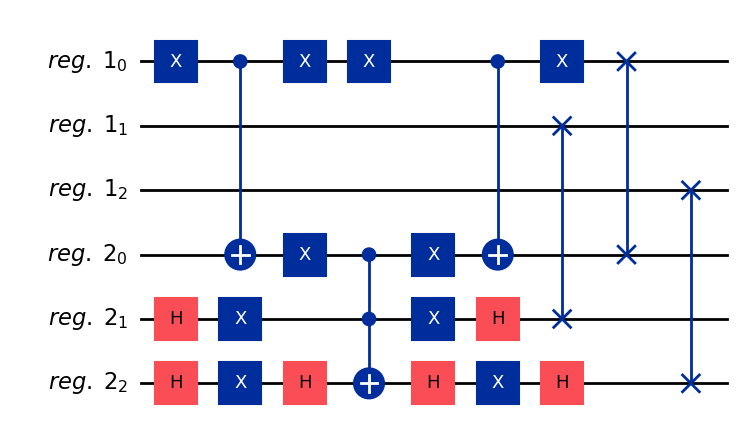

In [5]:
main_circ = QuantumCircuit()

main_circ.add_register(qr_1)
main_circ.add_register(qr_2)

main_circ = main_circ.compose(update_circ.inverse())
main_circ.x([3,4,5])
main_circ.h(5)
main_circ.ccx(3,4,5)
main_circ.h(5)
main_circ.x([3,4,5])
main_circ = main_circ.compose(update_circ)

main_circ.swap([0,1,2],[3,4,5])

main_circ.draw('mpl')

We compose the circuits to check that the quantum walk algorithm works.

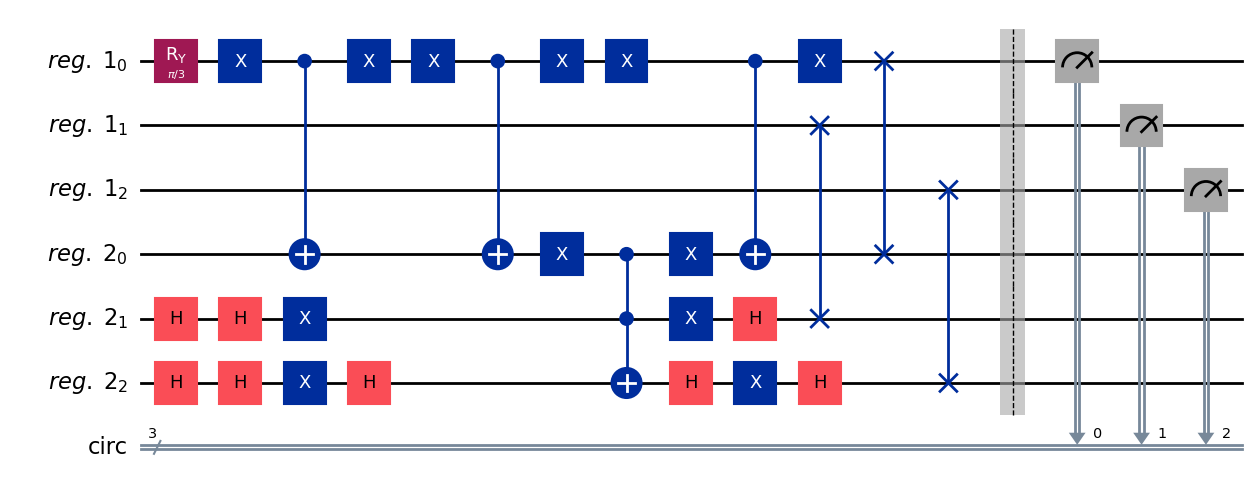

In [6]:
# Compose the circuits.
simulation_circ = main_circ.copy()
simulation_circ = simulation_circ.compose(init_circ,front=True,qubits=init_circ.qubits)

# Set the qubits for the results.
measured_qubits = qr_1

# Measure the qubits in a classical register.
circ_classical_reg = ClassicalRegister(len(measured_qubits),'circ')
simulation_circ.add_register(circ_classical_reg)
simulation_circ.barrier()
simulation_circ.measure(measured_qubits,circ_classical_reg)

simulation_circ.draw('mpl')

Qiskit uses little-endian order for the bits, so that when measuring, the first bit in the result is the one at bottom. However, in our library CQC-QHE [[2]](https://arxiv.org/abs/2412.01966) we use big-endian order, so that the uppermost bit is the first one. To obtain the results in the correct order, we use our function ``run``.

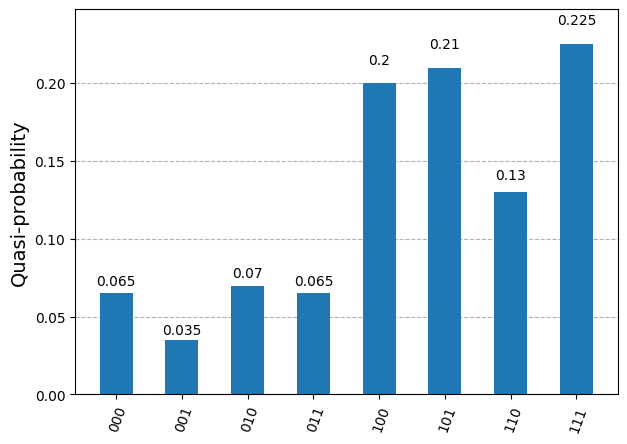

In [7]:
shots = 100
shots = 200
# shots = 1024
# shots = 20000  # This takes too much time.

counts = cqc.run_circuit(simulation_circ,shots)
plot_distribution(counts)

We use the helper function ``counts_to_probability_distribution`` to convert the counts into a probability distribution.

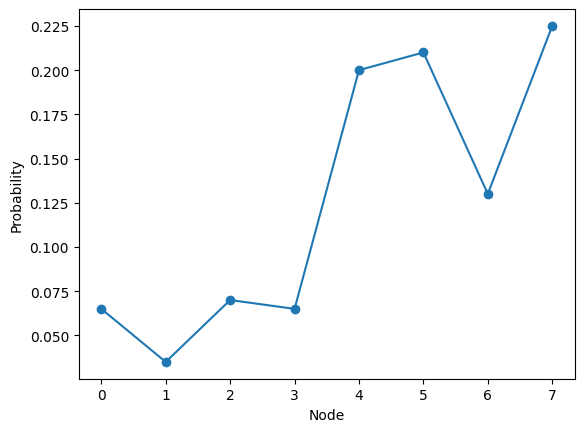

In [8]:
probability_distribution = cqc.counts_to_probability_distribution(counts)
plt.plot(probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.show()

<a name='2'></a>
## 2 - Compiling the quantum circuit into Clifford+T gates

For the homomorphic simulation we need the main circuit that Server must run to be compiled into Clifford+T gates. We use our function ``compile_clifford_t_circuit``.

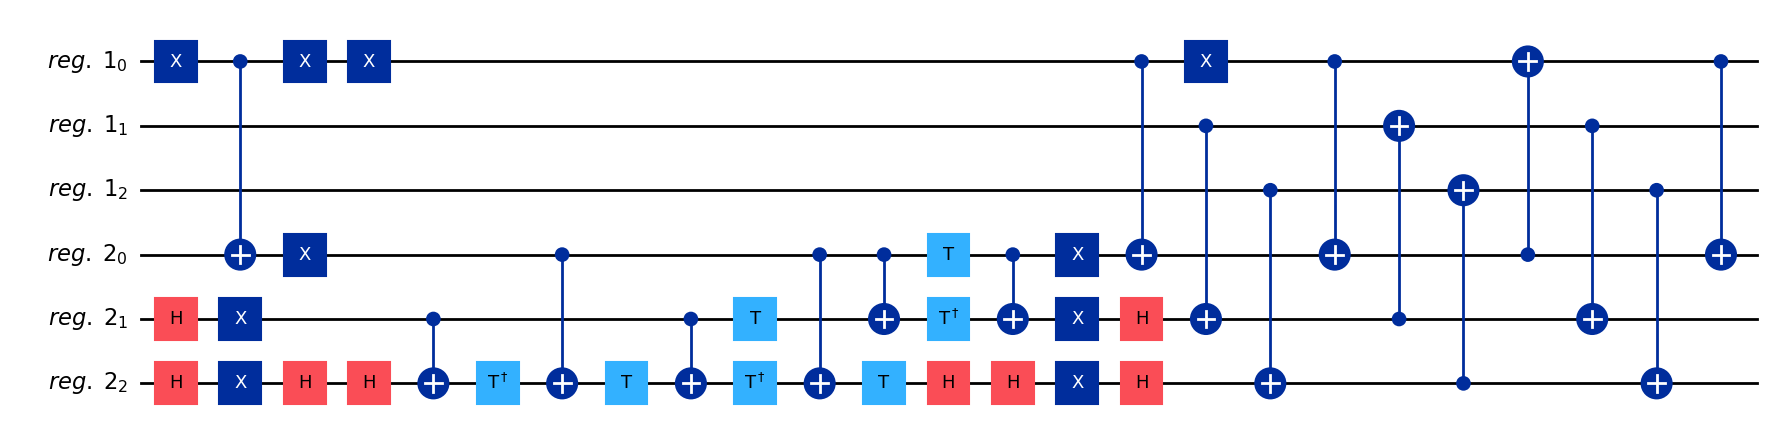

In [9]:
compiled_main_circ = cqc.compile_clifford_t_circuit(main_circ)

compiled_main_circ.draw('mpl')

Now, the circuit is composed of Clifford+T gates. We compose it again with the initial circuit of Client to check that the algorithm works.

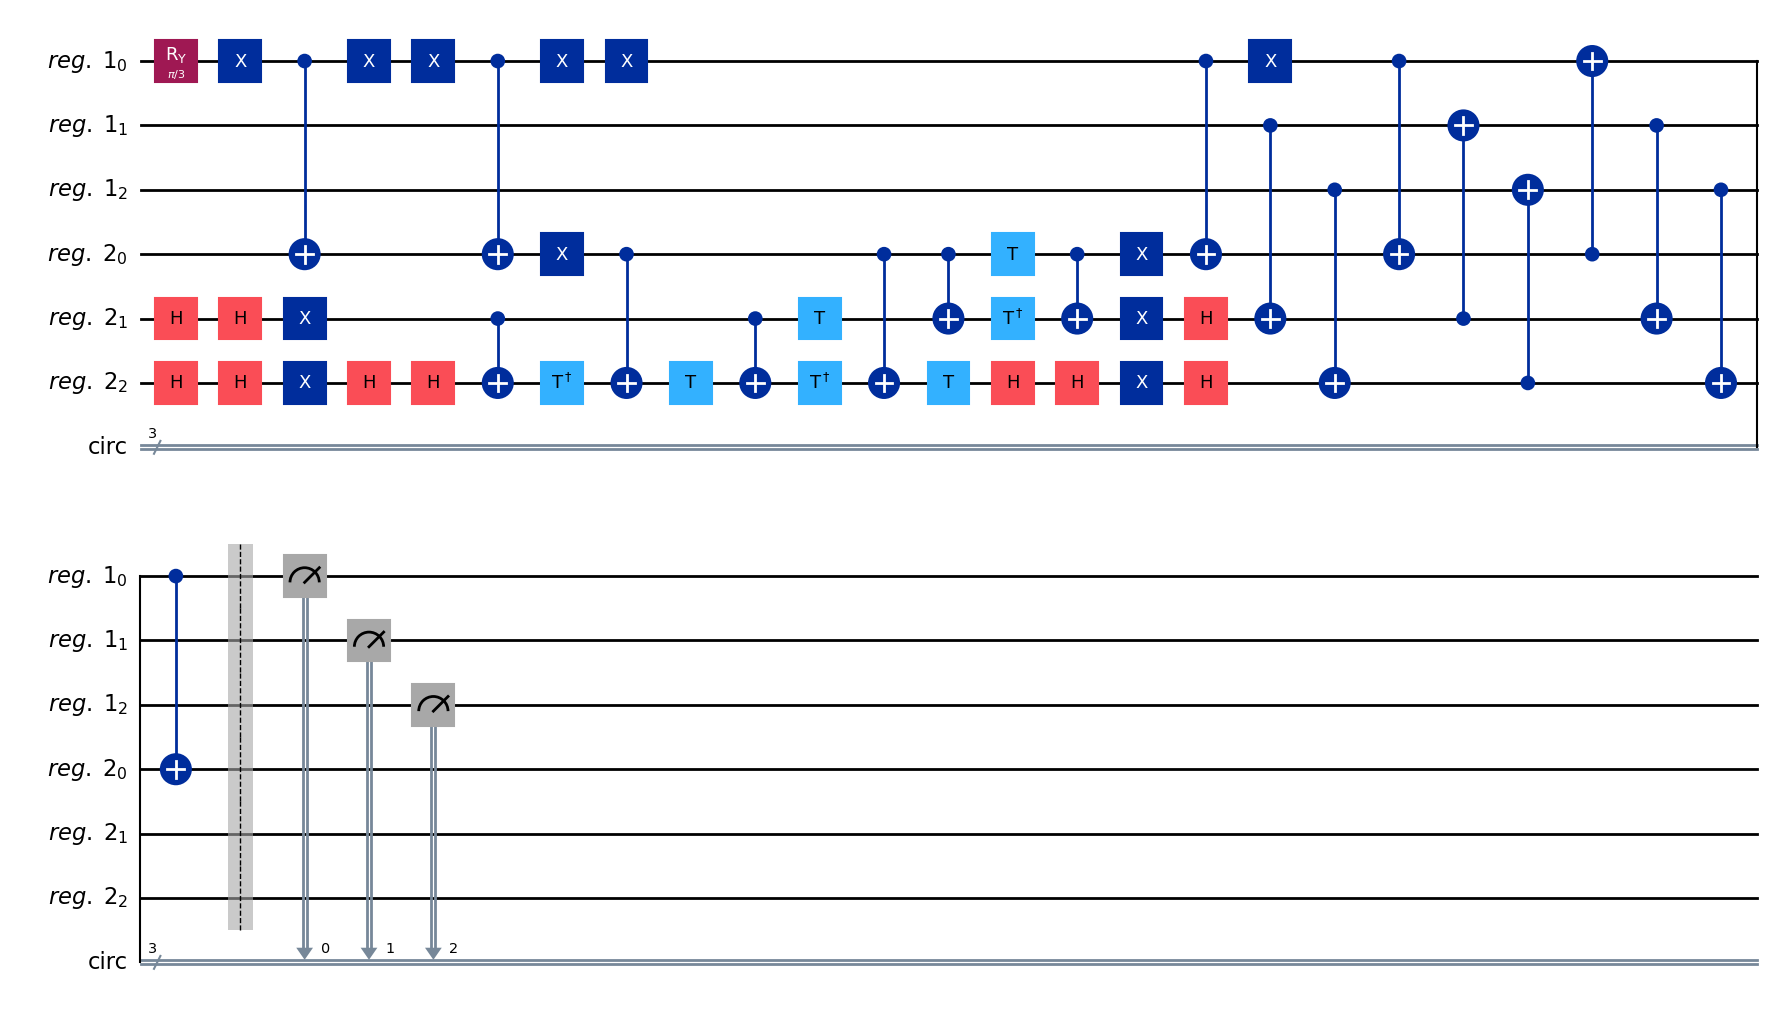

In [10]:
# Compose the circuits.
compiled_simulation_circ = compiled_main_circ.copy()
compiled_simulation_circ = compiled_simulation_circ.compose(init_circ,front=True,qubits=init_circ.qubits)

# Set the qubits for the results.
measured_qubits = qr_1

# Measure the qubits in a classical register.
circ_classical_reg = ClassicalRegister(len(measured_qubits),'circ')
compiled_simulation_circ.add_register(circ_classical_reg)
compiled_simulation_circ.barrier()
compiled_simulation_circ.measure(measured_qubits,circ_classical_reg)

compiled_simulation_circ.draw('mpl')

We obtain the same resuts as before when measuring.

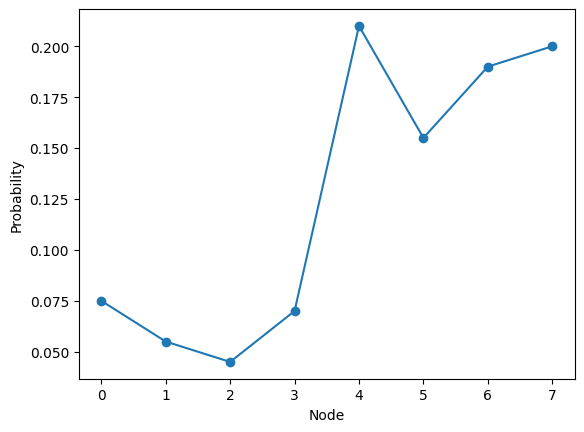

In [11]:
compiled_counts = cqc.run_circuit(compiled_simulation_circ,shots)

compiled_probability_distribution = cqc.counts_to_probability_distribution(compiled_counts)
plt.plot(compiled_probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.show()

<a name='3'></a>
## 3 - Homomorphic simulation

For the homomorphic simulation, we need to create a circuit that first implements the initial circuit of Client, then the circuit of Sever with the appropiate rules for the $T/T^\dagger$ gates and creation of Bell pairs in the ancilla qubits, and finally the circuit of Client that updates the keys and measures the final state.

We use the function ``create_homomorphic_circuit``.

In [12]:
homomorphic_circuit = cqc.create_homomorphic_circuit(init_circ,compiled_main_circ,measured_qubits)

# homomorphic_circuit.draw('mpl')
len(homomorphic_circuit.qubits)

20

We run the circuit. As it has 20 qubits, it takes far more time than before.

In this case, the results have several classical registers in the bitstrings. The measurements of the qubits of the main circuit correspond to the last register. We take the counts of this classical register with the function ``last_register_counts``.

In [13]:
homomorphic_counts = cqc.run_circuit(homomorphic_circuit,shots)

encrypted_counts = cqc.last_register_counts(homomorphic_counts)

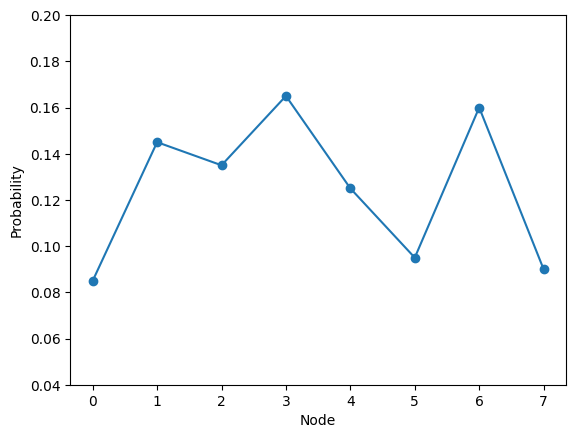

In [14]:
encrypted_probability_distribution = cqc.counts_to_probability_distribution(encrypted_counts)
plt.plot(encrypted_probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.ylim([0.04,0.2])
plt.show()

The results are encrypted, so we do not obtain the correct results obtained before. We decrypt them with the function ``decrypt_counts``.

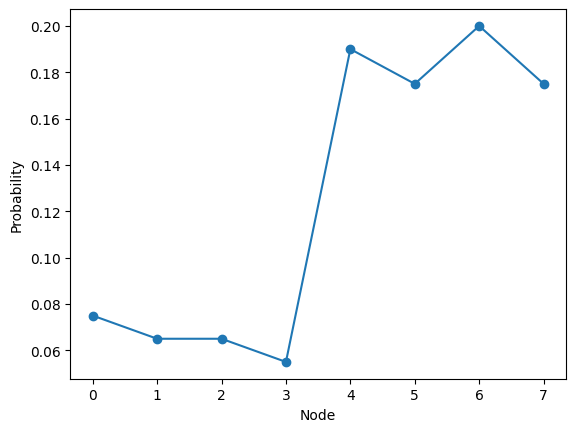

In [15]:
measured_positions = [0,1,2]

decrypted_counts = cqc.decrypt_counts(homomorphic_counts,measured_positions)

decrypted_probability_distribution = cqc.counts_to_probability_distribution(decrypted_counts)
plt.plot(decrypted_probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.show()

<a name='4'></a>
## 4 - Simplified homomorphic simulation

The homomorphic circuit contains 20 qubits, since we need 2 qubits for each of the 7 $T/T^\dagger$ gates, plus the 6 original qubits. In the supplementary material of [[2]](https://arxiv.org/abs/2412.01966) we show a method for simplifying the simulation using only 2 qubits for all the $T/T^\dagger$ gates. We create this simplified circuit with the function ``create_simplified_homomorphic_circuit``.

In [16]:
simplified_homomorphic_circuit = cqc.create_simplified_homomorphic_circuit(init_circ,compiled_main_circ,measured_qubits)

# simplified_homomorphic_circuit.draw('mpl')

When running the circuit, we obtain similar results to the realistic homomorphic circuit. However, it takes much less time.

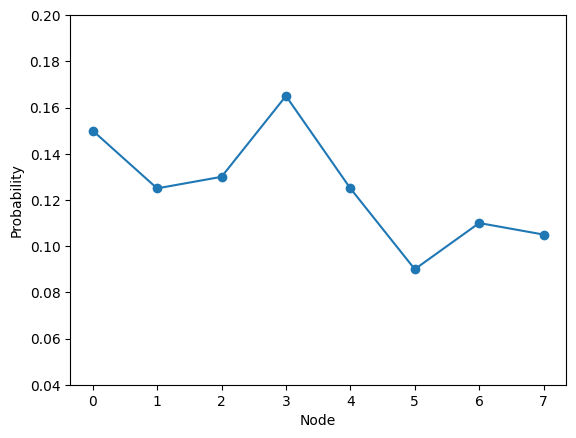

In [17]:
simplified_homomorphic_counts = cqc.run_circuit(simplified_homomorphic_circuit,shots)

simplified_encrypted_counts = cqc.last_register_counts(simplified_homomorphic_counts)

simplified_encrypted_probability_distribution = cqc.counts_to_probability_distribution(simplified_encrypted_counts)
plt.plot(simplified_encrypted_probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.ylim([0.04,0.2])
plt.show()

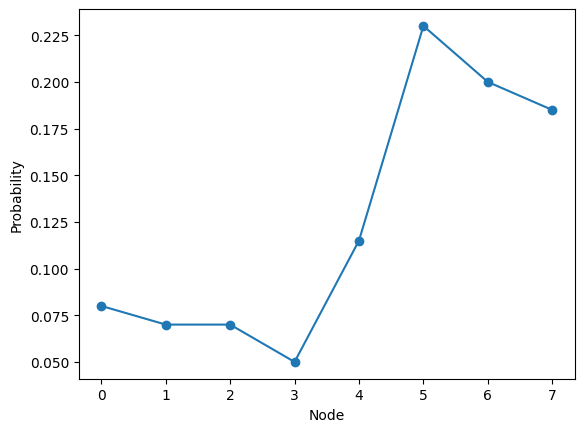

In [18]:
measured_positions = [0,1,2]

simplified_decrypted_counts = cqc.decrypt_counts(simplified_homomorphic_counts,measured_positions)

simplified_decrypted_probability_distribution = cqc.counts_to_probability_distribution(simplified_decrypted_counts)
plt.plot(simplified_decrypted_probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.show()

<a name='5'></a>
## 5 - Deterministic simulation with SQUWALS

Finally we show the probability distribution obtained deterministically using SQUWALS [[3]](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202400022). This python library can be downloaded at https://github.com/OrtegaSA/SQUWALS-repo.

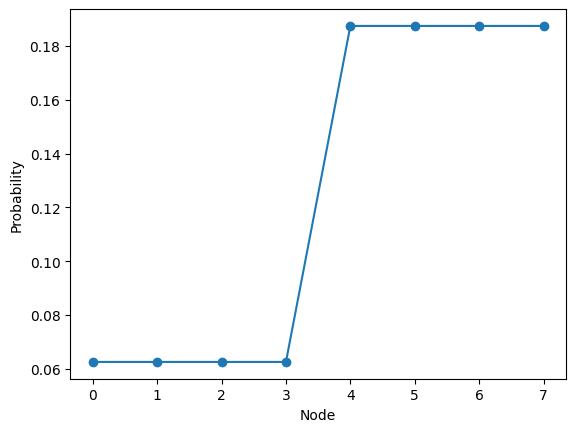

In [19]:
import squwals as sw

# Number of nodes of the bipartite graph.
N1 = 4
N2 = 4

# Transition matrix G.
G = np.zeros([N1+N2,N1+N2])
G[N1:,:N1] = 1
G[:N1,N1:] = 1
G = G/sum(G)

# Initial quantum state.
p1 = 0.25
p0 = 1-p1
initial_state = sw.create_initial_state(transition_matrix=G,coefficients=[np.sqrt(p0),np.sqrt(p1)],nodes=[0,4])

# Unitary evolution operator.
R = sw.Reflection(G)
S = sw.Swap()
U = S * R

# Simulate the quantum walk for a single step and measure the first register.
deterministic_probability_distribution = sw.quantum_szegedy_simulator(unitary=U,initial_state=initial_state,time_steps=1,measure=1)[-1]

plt.plot(deterministic_probability_distribution,'-o')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.show()

We compare the results with the QHE scheme.

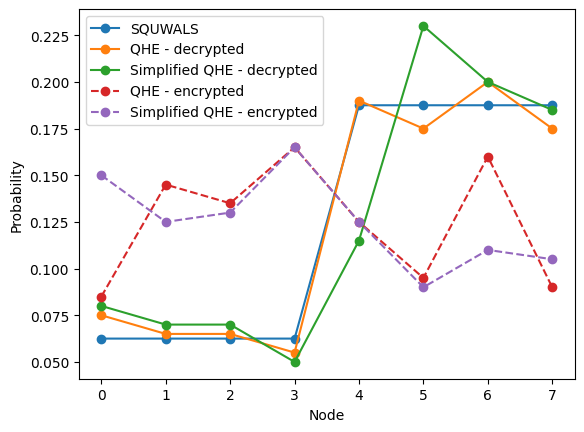

In [20]:
plt.plot(deterministic_probability_distribution,'-o',label='SQUWALS')
plt.plot(decrypted_probability_distribution,'-o',label='QHE - decrypted')
plt.plot(simplified_decrypted_probability_distribution,'-o',label='Simplified QHE - decrypted')
plt.plot(encrypted_probability_distribution,'--o',label='QHE - encrypted')
plt.plot(simplified_encrypted_probability_distribution,'--o',label='Simplified QHE - encrypted')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.legend()
plt.show()

<a name='6'></a>
## 6 - References

- [1] **[M. Szegedy. Quantum speed-up of Markov chain based algorithms. 45th Annual IEEE Symposium on Foundations of Computer Science, 32–41, 2004.](https://ieeexplore.ieee.org/document/1366222)**
- [2] **[S. A Ortega, P. Fernández and M. A. Martin-Delgado. Implementing Semiclassical Szegedy Walks in Classical-Quantum Circuits for Homomorphic Encryption. arXiv:2412.01966](https://arxiv.org/abs/2412.01966)**
- [3] **[S. A Ortega and M. A. Martin-Delgado. SQUWALS: A Szegedy QUantum WALks Simulator. Advanced Quantum Technologies, 2400022, 2024.](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202400022)**